# 2. SHO Fitting in Pytorch


In [1]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.nn.Regularization.Regularizers import NegValLoss
# from m3_learning.be.nn import SHO_Model, SHO_NN_Model, SHO_fit_func_nn

# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './../../../Figures/2023_rapid_fitting/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

# import matplotlib.pyplot as plt
# import numpy as np

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# from scipy.signal import resample
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import mean_squared_error

from m3_learning.optimizers.AdaHessian import AdaHessian
# from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
# from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
# from m3_learning.util.preprocessing import global_scaler
# from m3_learning.nn.random import random_seed
# from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
# from m3_learning.be.dataset import BE_Dataset
# from m3_learning.viz.style import set_style

# set_style("printing")

2023-05-08 09:40:59.409010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 09:40:59.526611: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-08 09:40:59.948530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-08 09:40:59.948580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads Data


In [3]:
# Specify the filename and the path to save the file
filename = "data_raw.h5"
save_path = "./../../../Data/2023_rapid_fitting"


data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins=80, SHO_fit_func_NN=SHO_fit_func_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data_Reshaped
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ raw_data_resampled
├ Raw_Data-SHO_Fit_000
  --------------------
  ├ Fit
  ├ Guess
  ├ SHO_LSQF
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ comp

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model.

Note: This uses the results from the least squares fitting LSQF results.


In [4]:
true = {"fitter": "NN", "resampled": False, "label": "NN Fit"}

predicted = {"fitter": "LSQF", "resampled": False, "label": "Raw", "scaled": False}

BE_viz = Viz(dataset, printing, verbose=True)

In [5]:
dataset.extraction_state


                  Resample = False
                  Raw Format = complex
                  fitter = LSQF
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  


True 


                  Resample = False
                  Raw Format = complex
                  fitter = NN
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
predicted 


                  Resample = False
                  Raw Format = complex
                  fitter = LSQF
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_7_PyTorch_fit_tester.png
./../../../Figures/2023_rapid_fitting/Figure_7_PyTorch_fit_tester.svg


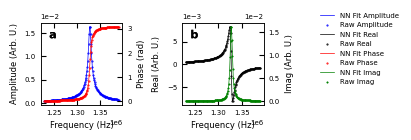

In [6]:
BE_viz.fit_tester(true, predicted, filename="Figure_7_PyTorch_fit_tester")

**Figure 7** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.


## Pytorch Model

### Model Architecture


### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data



                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.png
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.svg


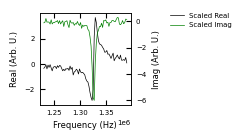

In [7]:
BE_viz = Viz(dataset, printing, verbose=True)


state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.



                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.svg


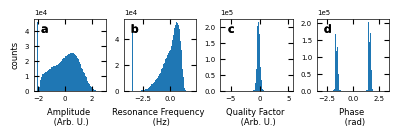

In [8]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms"
)

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.


### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.


In [9]:
random_seed(seed=42)

# instantiate the model
model = SHO_Model(dataset, training=True, model_basename="SHO_Fitter_original_data")

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090


In [10]:
import torch_optimizer as optml

train = False

if train:
    # fits the model
    model.fit(
        dataset.X_train,
        500,
        optimizer="Adam",
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.052957967706552825.pth"
    )

### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:593: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


torch.Size([1105920, 4])
torch.Size([3, 4])
./../../../Figures/2023_rapid_fitting/Figure_10_NN_validation_Train.png
./../../../Figures/2023_rapid_fitting/Figure_10_NN_validation_Train.svg


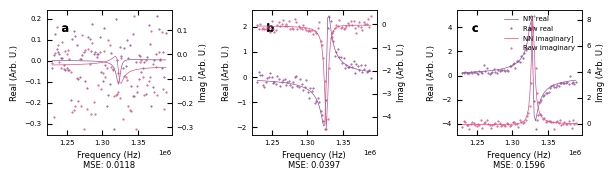

In [11]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    out_state={"scaled": True, "measurement_state": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

**Figure 10** Raw data and reconstruction of the autoendcoder for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.


torch.Size([276480, 4])
torch.Size([3, 4])
./../../../Figures/2023_rapid_fitting/Figure_11_NN_validation_test.png
./../../../Figures/2023_rapid_fitting/Figure_11_NN_validation_test.svg


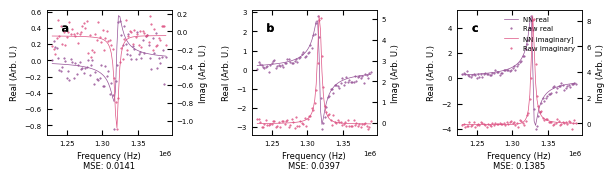

In [12]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_11_NN_validation_test",
)

**Figure 11** Raw data and reconstruction of the autoendcoder for the test data. Shows the a) best, b) median, and c) worst reconstruction of the test data.


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:593: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


torch.Size([1382400, 4])
torch.Size([3, 4])
./../../../Figures/2023_rapid_fitting/Figure_12_NN_validation_full_data.png
./../../../Figures/2023_rapid_fitting/Figure_12_NN_validation_full_data.svg


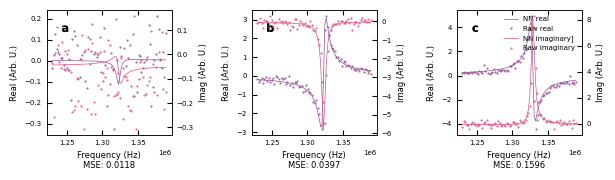

In [13]:
state = {
    "fitter": "LSQF",
    "measurement_state": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_12_NN_validation_full_data",
)

**Figure 12** Raw data and reconstruction of the autoendcoder for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.


### Calculate the MSE error

We can calculate the MSE error for the training, test, and entire data set.


In [14]:
X_data, Y_data = dataset.NN_data()

data = (X_data, X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]


model.print_mse(data, labels)

Full Data Mean Squared Error: 0.0449
Test Data Mean Squared Error: 0.0448
Train Data Mean Squared Error: 0.0449


From here on out we will assume that the autoencoder is working correctly, and is not overfit. This is a good assumption because the results are more or less the same for the training, test, and entire data set.


### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.


In [15]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)

Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 2.450513 ± 0.042733
Average execution time per iteration (ms): 0.002451 ± 0.000043
Total execution time (s): 3.39 


### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.



                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = index
                  Measurement State = complex
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./../../../Figures/2023_rapid_fitting/Figure_13_NN_Unscaled_Parameters_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_13_NN_Unscaled_Parameters_Histograms.svg


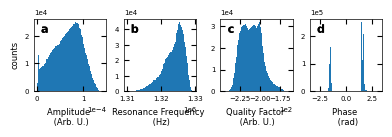

In [16]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_13_NN_Unscaled_Parameters_Histograms")

**Figure 13** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.


[autoreload of m3_learning.viz.layout failed: Traceback (most recent call last):
  File "/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 786, in exec_module
  File "<frozen importlib._bootstrap_external>", line 923, in get_code
  File "<frozen importlib._bootstrap_external>", line 853, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/ferroelectric/m3_learning/m3_learning/src


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = index
                  Measurement State = complex
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./../../../Figures/2023_rapid_fitting/Figure_13_NN_scaled_Parameters_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_13_NN_scaled_Parameters_Histograms.svg


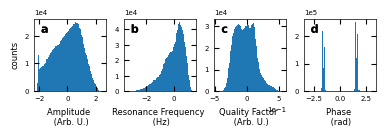

In [17]:
out = dataset.SHO_scaler.transform(parm)

BE_viz.SHO_hist(out, filename="Figure_13_NN_scaled_Parameters_Histograms")

**Figure 14** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase. The histograms show the scaled parameters.


In [ ]:
self = BE_viz

BE_viz.me

[0, 1.1866666666666672, 0.5183333333333334, 0.5183333333333334]
0
[2.2033333333333336, 1.1866666666666672, 0.5183333333333334, 0.5183333333333334]
1
[4.406666666666667, 1.1866666666666672, 0.5183333333333334, 0.5183333333333334]
2
[0, 0.6183333333333337, 0.5183333333333334, 0.5183333333333334]
3
[2.2033333333333336, 0.6183333333333337, 0.5183333333333334, 0.5183333333333334]
4
[4.406666666666667, 0.6183333333333337, 0.5183333333333334, 0.5183333333333334]
5
[0, 0.050000000000000266, 0.5183333333333334, 0.5183333333333334]
6
[2.2033333333333336, 0.050000000000000266, 0.5183333333333334, 0.5183333333333334]
7
[4.406666666666667, 0.050000000000000266, 0.5183333333333334, 0.5183333333333334]
8


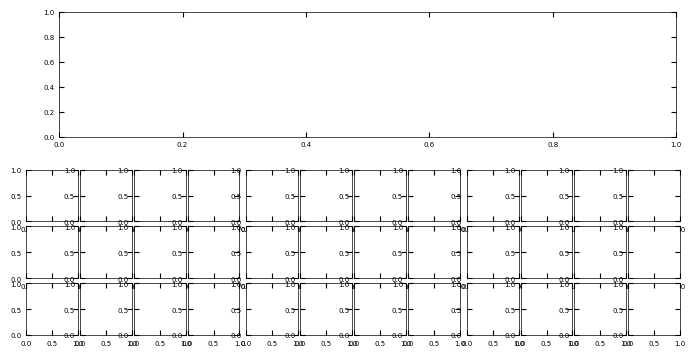

In [72]:
import matplotlib.pyplot as plt

# number of columns for the embedddings 
cols = 3
fig_width = 6.5

ax = []

# number of steps on the graph
number_of_steps = 9

voltage_plot_height = 1.25


# the gap between the graphs
intra_gap = 0.02
inter_gap = 0.05

# number of rows
rows = np.ceil(number_of_steps / 3)

# calculates the size of the embedding image 
embedding_image_size = (fig_width - (inter_gap * (cols - 1)) - intra_gap * 3 * cols) /(cols * 4)

# calculates the figure height based on the image details
fig_height = rows * (embedding_image_size + inter_gap) + voltage_plot_height + .33

# defines a scalar to convert inches to relative coordinates
fig_scalar = fig_dim_converter((fig_width, fig_height))

# creates the figure
fig = plt.figure(figsize=(fig_width, fig_height))

#left bottom width height
pos_inch = [0.33 , fig_height - voltage_plot_height, 6.5 - .33, voltage_plot_height]

# adds the plot for the voltage
ax.append(fig.add_axes(fig_scalar.to_relative(pos_inch)))

# resets the x0 position for the embedding plots
pos_inch[0] = 0
pos_inch[1] -= embedding_image_size + 0.33

# sets the embedding size of the image
pos_inch[2] = embedding_image_size
pos_inch[3] = embedding_image_size 

# adds the embedding plots
for i in range(number_of_steps):

    # loops around the amp, phase, and freq
    for j in range(4):
       
        # adds the plot to the figure
        ax.append(fig.add_axes(fig_scalar.to_relative(pos_inch))) 
        
        # adds the interplot gap
        pos_inch[0] += embedding_image_size + intra_gap

    # if the last column in row, moves the position to the next row
    if (i+1) % cols == 0 and i != 0:
        
        # resets the x0 position for the embedding plots
        pos_inch[0] = 0
        
        # moves the y0 position to the next row
        pos_inch[1] -= embedding_image_size + inter_gap
    else:
        # adds the small gap between the plots
        pos_inch[0] += inter_gap

ax[0]

    
fig.show()

In [71]:
6 %3

0

In [53]:
class fig_dim_converter:
    
    def __init__(self, figsize):
        
        self.fig_width = figsize[0]
        self.fig_height = figsize[1]
    
    def to_inches(self, x):
        
        return (x[0] * self.fig_width, x[1] * self.fig_height, x[2] * self.fig_width, x[3] * self.fig_height)
    
    def to_relative(self, x):
        
        return (x[0] / self.fig_width, x[1] / self.fig_height, x[2] / self.fig_width, x[3] / self.fig_height)
    

In [54]:
pos_inch

(0.33, 1.795, 6.17, 1.25)

In [55]:
fig_scalar.fig_height

3.045

In [45]:
fig_scalar.to_relative(pos_inch)

(0.050769230769230775,
 0.7821350762527233,
 0.9492307692307692,
 2.6884531590413943)

## Comparison SHO and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


(1382400, 4)
(3, 4)


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:593: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


torch.Size([1382400, 4])
torch.Size([3, 4])
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.png
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.svg


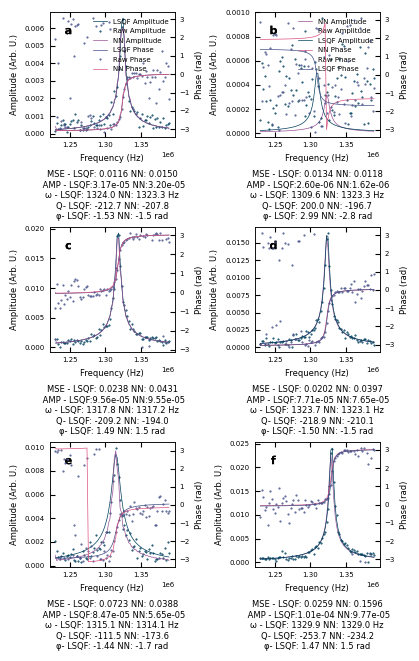

In [18]:
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2

true_state = {
    "fitter": "LSQF",
    "measurement_state": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

out_state = {"scaled": True, "measurement_state": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    # display_results = None
)

### Statistics of the Results for Training, Validation, and Entire Dataset


In [ ]:
# dataset.LSQF_phase_shift = 0

# state = {'fitter' : 'LSQF',
#              'resampled' : True,
#              'scaled' : False,
#              "measurement_state" : "complex"}

# BE_viz.set_attributes(**state)

# self = dataset

# fit_results = self.raw_spectra(fit_results = self.SHO_fit_results())

# fit_results = self.raw_data_scaler.transform(fit_results)

# fit_results = self.to_real_imag(fit_results)

# state = {'fitter' : 'LSQF',
#              'resampled' : True,
#              'scaled' : True,
#              "measurement_state" : "complex"}

# BE_viz.set_attributes(**state)

# raw = self.raw_spectra()

In [ ]:
# fit_results[0].shape

In [ ]:
# from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(fit_results[0].reshape(-1,80), raw[0].reshape(-1,80)) + mean_squared_error(fit_results[1].reshape(-1,80), raw[1].reshape(-1,80))

# mse /=2

In [ ]:
# import matplotlib.pyplot as plt

# i = np.random.randint(0, len(raw[0]))

# plt.plot(raw[0].reshape(-1,80)[i])
# plt.plot(fit_results[0].reshape(-1,80)[i])

### Visualization of the Distribution of the NN Fit Results

It is useful to check the distribution of the scaled and unscaled fit results for the entire dataset, this will also allow us to add a correction for a phase shift (if necessary).


#### Unscaled Histograms of Neural Network Fit Results


In [ ]:
# dataset.NN_phase_shift = 3*np.pi/2

# pred_data, scaled_param, parm = model.predict(X_train)

In [ ]:
#

In [ ]:
pred_data, scaled_param, parm = model.predict(X_data)

**Figure 10** Calculated fitting parameters from the neural network. Histograms of the unscaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.


#### Scaled Histograms of Neural Network Fit Results


In [ ]:
BE_viz.SHO_hist(scaled_param, filename="Figure_11_NN_Scaled_Histograms")

In [ ]:
BE_viz.SHO_hist(parm, filename="Figure_10_NN_Unscaled_Histograms")

In [ ]:
self = dataset

state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": True,
    "measurement_state": "complex",
}

BE_viz.set_attributes(**state)

raw = self.raw_spectra()

In [ ]:
3600 * 384

In [ ]:
from m3_learning.be.nn import SHO_fit_func_nn

out = SHO_fit_func_nn(parm, dataset.resampled_freq)

out = dataset.raw_data_scaler.transform(out)

out = dataset.to_real_imag(out)

In [ ]:
out[0].shape

In [ ]:
dataset.NN_phase_shift = 0

In [ ]:
import matplotlib.pyplot as plt

i = np.random.randint(0, len(raw[0]))

# plt.plot(out[0].reshape(-1,80)[i])
plt.plot(out[1].reshape(-1, 80)[i])
plt.plot(raw[1].reshape(-1, 80)[i])

plt.figure()
plt.plot(out[0].reshape(-1, 80)[i])
plt.plot(raw[0].reshape(-1, 80)[i])

**Figure 11** Calculated fitting parameters from the neural network. Histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.


### Model Validation

It is helpful to view reconstructions of the data from the training and validation datasets. This ensures that the model is doing a good job of fitting the data.


#### Random Training Data Fit


In [ ]:
BE_viz.nn_validation(
    model,
    X_train,
    filename="Figure_11_NN_Validation_example_training",
    SHO_results=y_train,
)

**Figure 11** A random reconstruction of the neural network fits for the training dataset


In [ ]:
BE_viz.nn_validation(
    model, X_test, filename="Figure_12_NN_Validation_example_test", SHO_results=y_test
)

**Figure 12** A random reconstruction of the neural network fits for the training dataset


In [ ]:
state = {
    "raw_format": "magnitude spectrum",
}

BE_viz.set_attributes(**state)

BE_viz.best_median_worst_reconstructions(
    model,
    X_data,
    SHO_values=Y_data,
    filename="Figure_13_NN_Best_Median_Worst_Reconstructions_Training",
)

In [ ]:
BE_viz.best_median_worst_reconstructions(
    model,
    X_test,
    SHO_values=y_test,
    filename="Figure 14_NN_Best_Median_Worst_Reconstructions_Testing",
)

Overall, the fit results are excellent for both the training and validation datasets.


In [ ]:
import pandas as pd

df = pd.DataFrame()


true = scaled_param
compare = dataset.SHO_fit_results().reshape(-1, 4)

true_df = pd.DataFrame(true, columns=["Amplitude", "Resonance", "Q-Factor", "Phase"])
predicted_df = pd.DataFrame(
    compare, columns=["Amplitude", "Resonance", "Q-Factor", "Phase"]
)

df = pd.concat((true_df, predicted_df))

# df = pd.DataFrame(np.vstack((true, compare)))

names = [true, compare]
names_str = ["SHO", "NN"]
labels = ["Amplitude", "Resonance", "Q-Factor", "Phase"]

for j, name in enumerate(names):
    for i, label in enumerate(labels):
        dict_ = {
            "value": name[:, i],
            "parameter": np.repeat(label, name.shape[0]),
            "dataset": np.repeat(names_str[j], name.shape[0]),
        }

        df = pd.concat((df, pd.DataFrame(dict_)))

In [ ]:
import pandas as pd

impoet


state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": True,
    "measurement_state": "complex",
}

BE_viz.set_attributes(**state)


true = scaled_param
compare = dataset.SHO_fit_results().reshape(-1, 4)

# build a dictionary:
DataNames = [true, compare]
labels = ["Amplitude", "Resonance", "Q-Factor", "Phase"]
names_str = ["NN", "SHO"]

df = pd.DataFrame()

for i, data in enumerate(DataNames):
    for j, signal in enumerate(labels):
        dict_ = {
            "value": data[:, j],
            "parameter": np.repeat(signal, data.shape[0]),
            "dataset": np.repeat(names_str[i], data.shape[0]),
        }

        df = pd.concat((df, pd.DataFrame(dict_)))

In [ ]:
import seaborn as sns

sns.violinplot(data=df, x="parameter", y="value", hue="dataset", split=True)

In [ ]:
import seaborn as sns
import pandas as pd

# Create a random dataset with two categories
data = pd.DataFrame(
    {
        "category": ["left"] * 100 + ["right"] * 100,
        "value": np.concatenate([np.random.randn(100), np.random.randn(100) + 2]),
    }
)

# Create a violin plot with left and right categories
sns.violinplot(x="category", y="value", hue="category", data=data, split=True)

In [ ]:
df.head()

In [ ]:
df.head()

## Comparison of NN and LSQF Results

It is useful to compare the NN and LSQF results. While generally, the LSQF results might be considered the ground truth, this is not really the case. It is unclear which fitting method is actually more precise and accurate. We conjecture through this analysis that the neural network is actually a more accurate and precise fitting method.

This section will help to make this case.


In [ ]:
state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": False,
    "raw_format": "magnitude spectrum",
}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results=dataset.SHO_fit_results())

state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": False,
    "raw_format": "magnitude spectrum",
}

BE_viz.set_attributes(**state)

raw_spectra = dataset.raw_spectra()

# ind, mse = BE_viz.best_median_worst_fit_comparison(LSQF_results, raw_spectra, 1, 1)

In [ ]:
BE_viz.best_median_worst_fit_comparison()

In [ ]:
self = BE_viz

# for the SHO curves it makes sense to determine the error based on the normalized fit results in complex form.
state = {
    "fitter": "LSQF",
    "resampled": False,
    "scaled": True,
    "raw_format": "complex",
}

self.set_attributes(**state)

fit_results_compare = self.dataset.raw_spectra(
    fit_results=self.dataset.SHO_fit_results()
)

raw_SHO = self.dataset.raw_spectra()

index1, mse1, d1, d2 = SHO_Model.get_rankings(raw_SHO, fit_results_compare, n=1)

In [ ]:
index1

In [ ]:
a = raw_SHO[0].reshape(-1, 165)[745386]
b = np.array(fit_results_compare[0].reshape(-1, 165)[745386])

a1 = raw_SHO[1].reshape(-1, 165)[745386]
b1 = np.array(fit_results_compare[1].reshape(-1, 165)[745386])

In [ ]:
(np.mean((a - b) ** 2) + np.mean((a1 - b1) ** 2)) / 2

In [ ]:
X_data.shape

In [ ]:
dataset.resampled_freq.shape

In [ ]:
plt.plot(dataset.frequency_bin)
plt.plot(dataset.resampled_freq, "o")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_data[745386, :, 0])
# plt.plot(dataset.frequency_bin, a)
# plt.plot(dataset.frequency_bin, b)

In [ ]:
state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": True,
    "raw_format": "complex",
}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results=dataset.SHO_fit_results())

In [ ]:
np.array(d1).shape

In [ ]:
d1[1][0].shape

In [ ]:
plt.plot(d1[0][0])
plt.plot(d1[1][0])
mse1[0]

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
index, mse, c1, c2 = SHO_Model.get_rankings(LSQF_results, raw_spectra, n=1, curves=True)

In [ ]:
c1.shape

In [ ]:
plt.plot(c1[0, 0])
plt.plot(c2[0, 0], "o")

In [ ]:
plt.plot(c1[2, :, 1])
plt.plot(c2[2, :, 1], "o")

In [ ]:
[tensor.numpy() for tensor in LSQF_results]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(LSQF_results[0][100, 100, :])
plt.plot(raw_spectra[0][100, 100, :])

In [ ]:
[0### LSQF NN compairison resonstruction

### LSQF NN comapairison distributions

### LSQF NN comparison movies.'